# Preprocessing

Although music genres are nowadays very hard to segregate (and it could result meaningless at a certain point), several audio platforms (as Spotify or iTunes) relate on gender classification to store the data and generate recommendations to the user.

After analysing the main characteristics of the audio files, preprocessing is achieved along with the feature extraction.

### Audio Channels and Sampling Frequency

Analysing the values obtained in the EDA notebook, it can be seen all the audio files are mono, with the same sampling rate and bit-depth. There is no need to resample or to modify any of these parameters.

In terms of the sampling frequency, librosa resamples audio files to 22050 Hz. This is something important to take care of, even though in this case there will be no modifications to the original files, as resampling is not involved.

In [1]:
import librosa as lb
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#plt.style.use('dark_background')

Also, librosa normalise the data so the resulting value range is between -1 and 1. This is used in order to unify the bit depth of all the dataset, that is already standardized.

## Feature Extraction

## 1. Mel-frequency Cepstral Coefficients (MFCC)

One of the most common features to extract in audio data are the Mel-frequency Cepstral Coefficients (MFCC). Those coefficients represent the Mel spectrogram or cepstrum. This diagram represents how they are calculated:

<div>
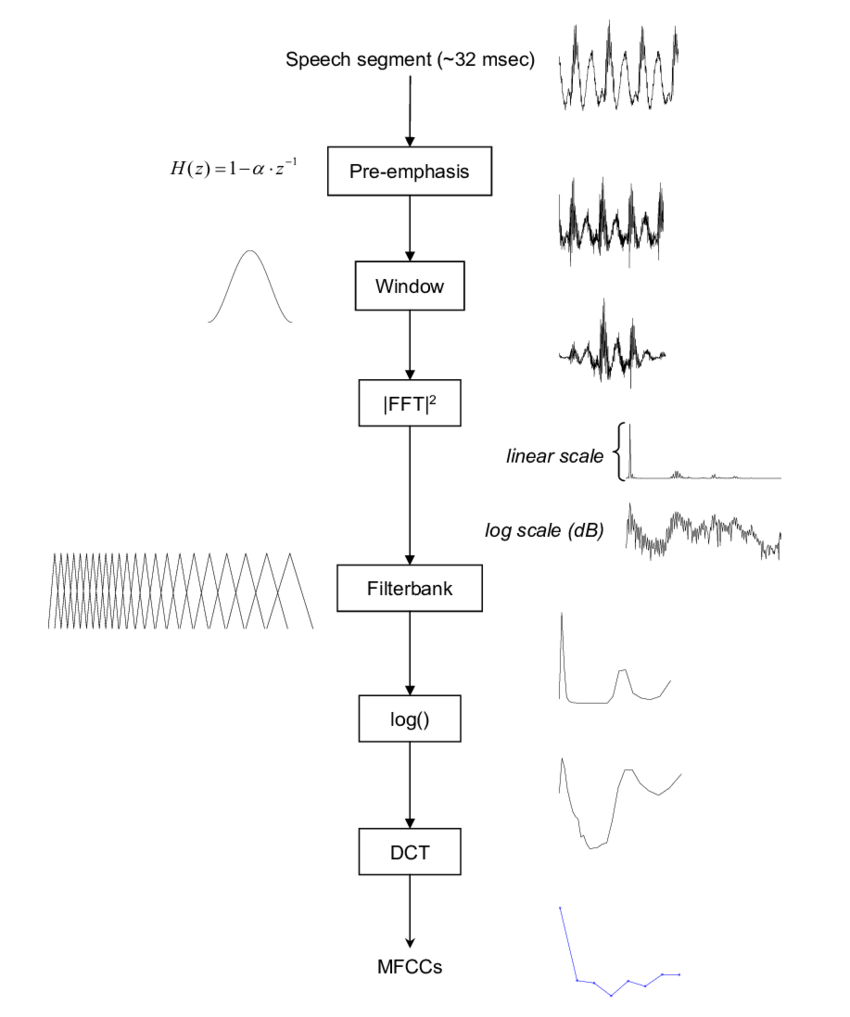
</div>

Source: _Acoustical Modeling for Speech Recognition: Long Units and Multi-Modeling_, Messina, R.

The resulting spectrogram is denominated __Cepstrum__. First, the logarithm of the Fourier Transform's magnitude is obtained. Then, the spectrum is calculated from the Discrete Cosine Transform of the previous logarithm (from frequency to "quefrency"). This resulting spectrum is called __Cepstrum__: it allows to analyse peaks where a periodic event ocurs in the original signal.

Another interesting concept is the __Mel Scale__. It relates the perceived frequency (by a human) of a sound to the real frequency of itself (it could be described as a perceptual pitch scale). The scale presents a mapping from Hertz to Mels in a non-linear representation (although it can be considered almost lineal up to 1 kHz); this way, the Mel Scale represents in a more approximate approach the human listening perception, scaling frequencies for this purpose. Frequencies can be transformed from Hertz to Mels using the following equation:

$$Mel (f) = 2595 log \left(1 + \dfrac{f}{700}\right)$$

Non-linear mapping from Hertz to Mels can be observed:

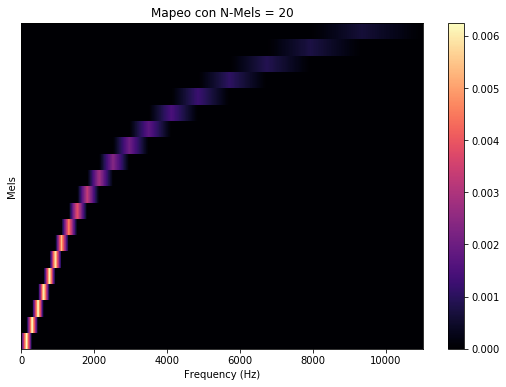

In [5]:
mel_20 = librosa.filters.mel(sr=freq_sampleo, n_fft=2048, n_mels=20)

plt.figure(figsize=(9, 6));

librosa.display.specshow (mel_20, x_axis='linear')
plt.ylabel('Mels')
plt.xlabel ('Frequency (Hz)')
plt.colorbar()
plt.title('Mapeo con N-Mels = 20')
plt.show()

Mel-frequency Cepstral Coefficients can be calculated using:

$$mfcc_m [n] = \dfrac{1}{R}\sum_{r=1}^{R} log (MF_m[n]) cos \left[ \dfrac{2\pi}{R} \left(r+\dfrac{1}{2} \right) n       \right]$$

_R_ relates to the amount of filters conforming the bank filter. The amount of filters is chosen in terms of the bandwidth of the analysed signal. Librosa uses equal heigth or equal energy filters.

## 2. Zero-crossing Rate

Represents the rate of sign-changes along a signal. In other words, it is related to the rate at which the signal changes from positive to negative (or back). This feature has been used heavily in both speech recognition and music information retrieval. It usually has higher values for highly percussive sounds. However, in terms of modern music, compression could generate lower zero-crossing rate, while in a more dynamical audio sample the value could increase.

Zero-crossing rate is defined formally as:

$$zcr = \dfrac{1}{T-1} \sum_{t=1}^{T-1} 1_{R >0} (s_t s_{t-1}) $$

Where _s_ is a signal of length _T_ and $$1_{R < 0}$$ is an indicator function. 


## 3. Spectral Centroid

It indicates where the ”centre of mass” for a sound is located and is calculated as the __weighted mean of the frequencies__ present in the sound. It is determined using a Fourier transform, with their magnitudes as the weights. This parameter indicates at which frequency the energy of a spectrum is centered upon. It can be defined with the following equation:

$$ f_c = \dfrac{\sum_{k}^{} S(k)f(k)}{\sum_{k}^{}S(k)}$$

## Feature Normalization

There are some features are expressed using different units; for example, Spectral Centroid and Zero-Crossing Rate. This is a discrepancy that can invoke some problems when performing classification later. 

Therefore, we will normalize each feature vector to a common range and store the normalization parameters for later use.

# Feature Extraction for one audio sample

The three features previoulsy mentioned (MFCC, Zero-Crossing Rate and Spectral Centroid) will be obtained for each audio file. First, a test will be made with some audio sample. We will load and plot our audio sample signal:

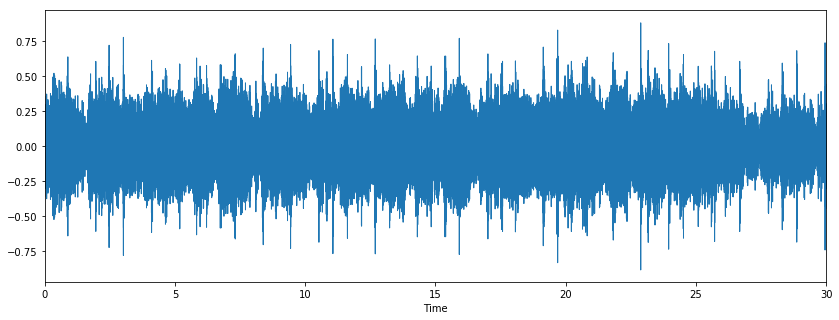

In [5]:
audio_sample, sampling_frequency = librosa.load('../v1.1/Audio Samples/metal.00002.wav')

plt.figure(figsize=(14,5))
librosa.display.waveplot(audio_sample, sr = sampling_frequency)

## 1. Mel-frequency Cepstral Coefficients

The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope. This time, we will use 20 Mel Coefficients.

In [6]:
mfccs = librosa.feature.mfcc(y = audio_sample, sr = sampling_frequency, n_mfcc=20)

print (mfccs.shape)

(20, 1293)


We have 20 MFCCs over 1293 frames. This frames are related to the DFT window used (512) and the audio file duration (30 seconds).This results in:

$$ 22050 * 30 /512 = 1293 $$

Analysing the resulting spectrogram:

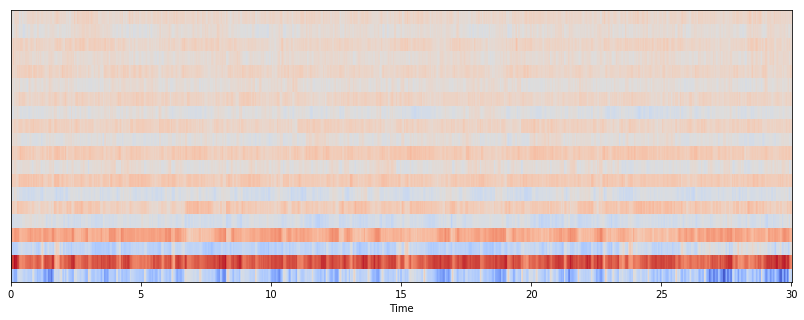

In [7]:
plt.figure(figsize=(14,5))
librosa.display.specshow(mfccs, sr = sampling_frequency, x_axis='time')

## 2. Zero-Crossing Rate

As we stated before, the Zero-Crossing rate indicates the number of times that a signal crosses the horizontal axis. For example, if we take a zoom in our audio signal and plot it, we can observe 4 crossing points.

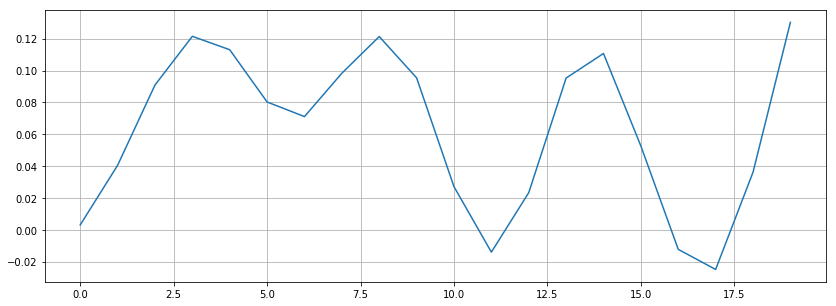

In [7]:
n0 = 500
n1 = 520
plt.figure(figsize=(14, 5))
plt.plot(audio_sample[n0:n1])
plt.grid()

In [8]:
zero_crossings = librosa.zero_crossings(audio_sample[n0:n1], pad=False)

/home/diego/anaconda2/lib/python2.7/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),


In [9]:
zero_crossings.shape

(20,)

Zero_crossings compute a binary mask where __True__ indicates the presence of a zero crossing. To find the total number of zero crossings, _sum_ has to be applied:

In [10]:
print(sum(zero_crossings))

4


Then, to calculate the zero-crossing rate for all the signal:

In [11]:
zcrs = librosa.feature.zero_crossing_rate(audio_sample)
print(zcrs.shape)

(1, 1293)


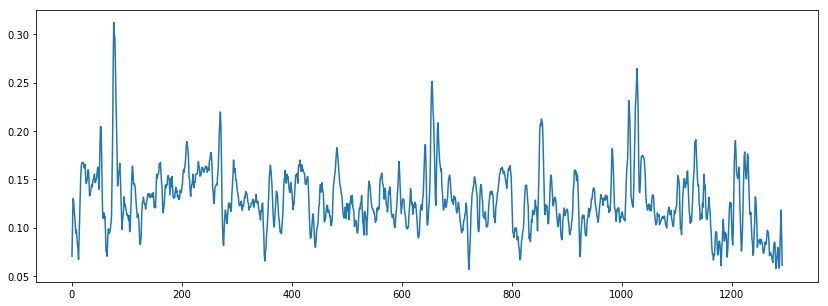

In [12]:
#Plotting the zero-crossing rate

plt.figure(figsize=(14, 5))
plt.plot(zcrs[0])

But, If we decided to see what is happening at the beggining, we can see a huge amount of zero crossings. The reason for the high rate near the beginning is because the silence oscillates quietly around zero:

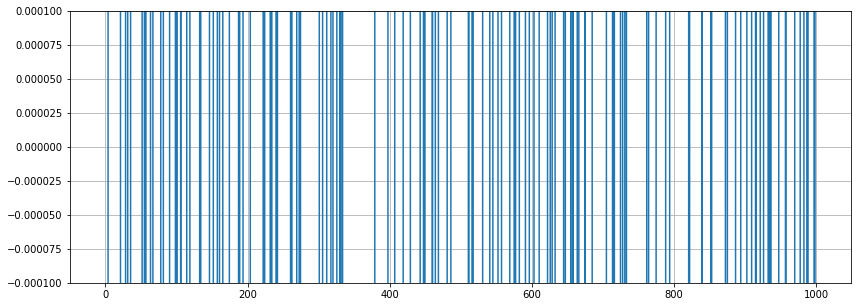

In [13]:
plt.figure(figsize=(14, 5))
plt.plot(audio_sample[:1000])
plt.ylim(-0.0001, 0.0001)
plt.grid()

We can get rid of this by adding a small constant before computing the zero crossing rate:

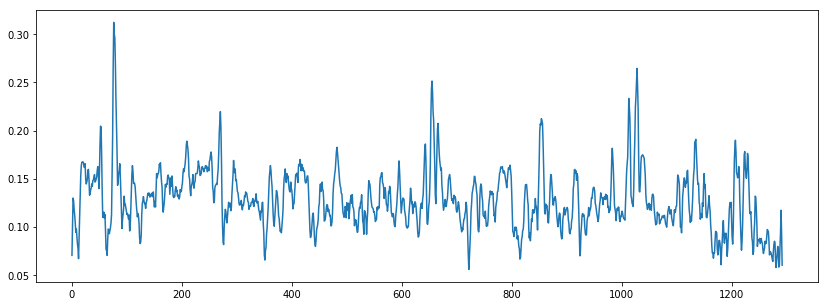

In [14]:
zcrs = librosa.feature.zero_crossing_rate(audio_sample + 0.0001)
plt.figure(figsize=(14, 5))
plt.plot(zcrs[0])

Zero-crossing rate tend to be more useful in monophonic recordings, or in source separation. However, let's try to see if we can obtain something interesting by using this feature on our models.

## 3. Spectral Centroid

As stated before, this paremeter indicates at which frequency the energy of a spectrum is centered upon.

In [34]:
spectral_centroids = librosa.feature.spectral_centroid(audio_sample, sr = sampling_frequency)[0]
spectral_centroids.shape

(1293,)

A plot of the signal itself along with the spectral centroid calculated is shown below:

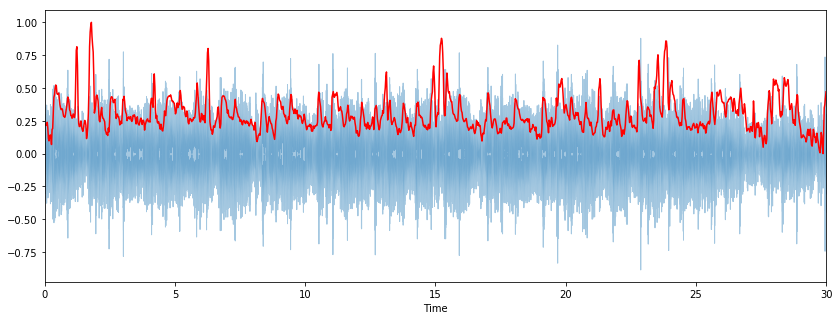

In [35]:
#For visualization purposes

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

plt.figure(figsize=(14,5))
librosa.display.waveplot(audio_sample, sr= sampling_frequency, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes

Where we can observe more peaks at the signal, this will mean a higher value for spectral centroid, due to impulsive sounds contaning majority of the frequency spectrum. This is just a normalized representation to compare the signal to its Spectral Centroid (Spectral Centroid took values related to Hertz). Spectral centroid is a good predictor of the "brightness" of a sound; thus it is widely used in digital audio and music processing as an automatic measure of musical _timbre_.

Also, the Spectral Centroid higher than one might intuitively expect, because there is so much more energy above (than below) the fundamental which contributes to the average. 

## Feature Extraction for the entire audio dataset

Then, we intended to extract the three features for each audio file in the dataset, and the store it in a Pandas Dataframe along with its classification label. Cepstral Mean and Variance Normalization is used (CMVN) for the MFCCs. We transpose the result of MFCC to accommodate scikit-learn which assumes that each row is one observation, and each column is one feature dimension. Mean values of the features are used.

In [2]:
#A extract features function is defined

def extract_features (file_name):

    audio, sampling_rate = librosa.load(file_name)
       
    #Zero-Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(audio))
    
    #Spectral Centroids
    spectral_centroids = np.mean(librosa.feature.spectral_centroid(audio, sr = sampling_rate))
    
    #MFCC (to list because mfccs returns an array)
    mfccs = np.mean(librosa.feature.mfcc(y = audio, sr = sampling_rate, n_mfcc = 20),axis=1).tolist()
    
    #Convert all to a list.
    features = [zcr,spectral_centroids]+ mfccs

    return features

First, we will test the extract features function, and try to concatenate some value representing "class_label"

In [3]:
data = extract_features('../v1.1/Audio Samples/blues.00000.wav')
test_data = [data[i] for i in range (len(data))]+['blues']
test_data

/home/diego/anaconda2/lib/python2.7/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),


[0.08304482066898686,
 1784.1658495387555,
 -113.57065006014837,
 121.57179828375645,
 -19.16814183078655,
 42.36641931081863,
 -6.364662969609985,
 18.62349792464522,
 -13.7048897059139,
 15.34314955543285,
 -12.274108441213581,
 10.97657055225877,
 -8.326572193800216,
 8.803791231568422,
 -3.672299421905222,
 5.747994547195348,
 -5.162881230931669,
 0.7527385539353303,
 -1.6902141675534035,
 -0.40898004185370507,
 -2.3035220174566313,
 1.2212897403748193,
 'blues']

As everything is working correctly, we will extract the features from all the dataset, and store them in a Pandas dataframe: 

In [5]:
# Defino el path absoluto donde estan localizados todos los audios

dataset_path = '/media/diego/4A64372E64371BDF/Downloads/Datasets/GTZAN/genres/'

# Leo la metadata 

metadata = pd.read_csv('/home/diego/ML/Audio Genre Classification/Metadata/metadata.csv')

# Preparo donde voy a colocar los features

features = []

# Itero a través de cada audio para obtener los nombres de los archivos y las clases

for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(dataset_path),str(row["label"])+'/',str(row["filename"]))
    class_label = row ["label"]
    
    # Extraigo los features para cada archivo
    
    data = extract_features (file_name)
    
    #Appendo en features []
    
    #features.append([data, class_label])
    features.append([data[i] for i in range (len(data))]+[class_label])    
    #features.append([class_label])
    
# Convierto a un pandas dataframe

features_df = pd.DataFrame(features, columns=['Zero-Crossing Rate','Spectral Centroid', 'MFCC1','MFCC2'
                                              ,'MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8','MFCC9'
                                              , 'MFCC10','MFCC11','MFCC12','MFCC13','MFCC14','MFCC15','MFCC16'
                                              , 'MFCC17', 'MFCC18', 'MFCC19', 'MFCC20', 'label'])



In [6]:
print (len(features_df))

1000


Will save the .csv file for future analysis:

In [7]:
features_df.to_csv('../v1.2/Metadata/features_df_v1.2.csv',index=False)

In [16]:
features_df = pd.read_csv('../v1.2/Metadata/features_df_v1.2.csv')
features_df.head()

,Zero-Crossing Rate,Spectral Centroid,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,...,MFCC12,MFCC13,MFCC14,MFCC15,MFCC16,MFCC17,MFCC18,MFCC19,MFCC20,label
0,0.083045,1784.165850,-113.570650,121.571798,-19.168142,42.366419,-6.364663,18.623498,-13.704890,15.343150,...,8.803791,-3.672299,5.747995,-5.162881,0.752739,-1.690214,-0.408980,-2.303522,1.221290,blues
1,0.056040,1530.176679,-207.501685,123.991259,8.955128,35.877647,2.907321,21.510467,-8.560437,23.370686,...,5.376327,-2.231760,4.220140,-6.012149,0.927997,-0.731124,0.295072,-0.283518,0.531216,blues
2,0.076291,1552.811865,-90.722595,140.446306,-29.093890,31.684336,-13.984503,25.764743,-13.664875,11.639933,...,5.791199,-8.907628,-1.077000,-9.229274,2.451689,-7.729093,-1.816408,-3.439720,-2.231259,blues
3,0.033309,1070.106615,-199.544200,150.090908,5.662679,26.859079,1.771400,14.234030,-4.832006,9.286495,...,6.079319,-2.480173,-1.079305,-2.870788,0.780873,-3.319597,0.636964,-0.619121,-3.407449,blues
4,0.101461,1835.004266,-160.337711,126.219631,-35.587809,22.148071,-32.478602,10.852293,-23.352330,0.498432,...,-2.813868,-6.933384,-7.552726,-9.164665,-4.520577,-5.454034,-0.916875,-4.404826,-11.703234,blues


## Categorical to numerical encoding

LabelEncoder is used to encode categorical data to numerical data.

In [17]:
### from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y = np.array (features_df.label.tolist())
#y = features_df.iloc[:,-1]

label_encoder = LabelEncoder()

#yy = to_categorical(label_encoder.fit_transform(y))
yy = label_encoder.fit_transform(y)

## Feature Scaling

Some features have very different units representing their values. Also, some features with broader range of values will overpower and bias the algorithm relative to the other features with narrower range of values. To avoid this, we must first normalize our data. There are a few methods to do this, but a common way is through standardization. We will change to MinMaxScaler this time, in order to fed our Neural Network values between 0 and 1. However, MinMax Scaler is more affected by outliers than StandardScaler. Let's see it:

In [18]:
scaler = MinMaxScaler()
X = scaler.fit_transform(np.array(features_df.iloc[:, :-1], dtype = float))

## Splitting the dataset

The sklearn function __train_test_split__ is used to separate the whole dataset in train (80%) and test dataset (20%).

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size = 0.2, random_state=42) 

In [20]:
len(x_train)

800

In [21]:
x_train

array([[0.12334406, 0.27910427, 0.5358914 , ..., 0.19158298, 0.25569789,
        0.16724164],
       [0.06337108, 0.07090029, 0.48846717, ..., 0.2465772 , 0.50111166,
        0.46533992],
       [0.39306643, 0.48541488, 0.86960585, ..., 0.56530076, 0.45833737,
        0.66813829],
       ...,
       [0.38272879, 0.47227749, 0.42187432, ..., 0.34037668, 0.39186322,
        0.32653651],
       [0.32314855, 0.58396465, 0.75952342, ..., 0.6366295 , 0.64139486,
        0.66811512],
       [0.27022403, 0.2380819 , 0.53330182, ..., 0.54507259, 0.50748527,
        0.48254386]])

Finally, data is stored to use in future notebooks

In [22]:
%store x_train 
%store x_test 
%store y_train 
%store y_test 
%store yy 
%store label_encoder

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'yy' (ndarray)
Stored 'label_encoder' (LabelEncoder)
